In [1]:
import os

os.environ["CHARMM_HOME"] = "/pchem-data/meuwly/boittier/home/charmm"
os.environ["CHARMM_LIB_DIR"] = "/pchem-data/meuwly/boittier/home/charmm/build/cmake"
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax

# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import sys
import e3x
import jax
import numpy as np
import optax
import orbax
from pathlib import Path
import pandas as pd

# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test")
import physnetjax

sys.path.append("/pchem-data/meuwly/boittier/home/dcm-lj-data")
from pycharmm_lingo_scripts import script1, script2, script3, load_dcm

from physnetjax.data.data import prepare_datasets
from physnetjax.training.loss import dipole_calc
from physnetjax.models.model import EF
from physnetjax.training.training import train_model  # from model import dipole_calc
from physnetjax.data.batches import (
    _prepare_batches as prepare_batches,
)  # prepare_batches, prepare_datasets

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)

from pathlib import Path

from physnetjax.calc.helper_mlp import get_ase_calc


def parse_non_int(s):
    return "".join([_ for _ in s if _.isalpha()]).lower().capitalize()


read_parameter_card = """
read parameter card
* methanol
*
NONBONDED
CG321    0.0       {CG321EP:.4f}     {CG321RM:.4f}   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       {CLGA1EP:.4f}    {CLGA1RM:.4f} ! CLET, DCLE, chloroethane, 1,1-dichloroethane
END
"""
# HGA2     0.0       -0.0200     1.3400 ! alkane, yin and mackerell, 4/98


NATOMS = 10

model = EF(
    # attributes
    features=128,
    max_degree=0,
    num_iterations=5,
    num_basis_functions=64,
    cutoff=10.0,
    max_atomic_number=18,
    charges=True,
    natoms=NATOMS,
    total_charge=0,
    n_res=3,
    zbl=False,
    debug=False,
)


import pycharmm

import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm


import ase
from ase.io import read as read_ase
from ase import visualize
from ase.visualize import view


from scipy.optimize import minimize

ev2kcalmol = 1 / (ase.units.kcal / ase.units.mol)


def set_pycharmm_xyz(atom_positions):
    xyz = pd.DataFrame(atom_positions, columns=["x", "y", "z"])
    coor.set_positions(xyz)


def capture_neighbour_list():
    # Print something
    distance_command = """
    open unit 1 write form name total.dmat
    
    COOR DMAT SINGLE UNIT 1 SELE ALL END SELE ALL END
    
    close unit 1"""
    _ = pycharmm.lingo.charmm_script(distance_command)

    with open("total.dmat") as f:
        output_dmat = f.read()

    atom_number_type_dict = {}
    atom_number_resid_dict = {}

    pair_distance_dict = {}
    pair_resid_dict = {}

    for _ in output_dmat.split("\n"):
        if _.startswith("*** "):
            _, n, resid, resname, at, _ = _.split()

            n = int(n.split("=")[0]) - 1
            atom_number_type_dict[n] = at
            atom_number_resid_dict[n] = int(resid) - 1

    for _ in output_dmat.split("\n"):
        if _.startswith("  "):
            a, b, dist = _.split()
            a = int(a) - 1
            b = int(b) - 1
            dist = float(dist)
            if atom_number_resid_dict[a] < atom_number_resid_dict[b]:
                pair_distance_dict[(a, b)] = dist
                pair_resid_dict[(a, b)] = (
                    atom_number_resid_dict[a],
                    atom_number_resid_dict[b],
                )

    return {
        "atom_number_type_dict": atom_number_type_dict,
        "atom_number_resid_dict": atom_number_resid_dict,
        "pair_distance_dict": pair_distance_dict,
        "pair_resid_dict": pair_resid_dict,
    }


def get_forces_pycharmm():
    positions = coor.get_positions()
    force_command = """coor force sele all end"""
    _ = pycharmm.lingo.charmm_script(force_command)
    forces = coor.get_positions()
    coor.set_positions(positions)
    return forces


def view_atoms(atoms):
    return view(atoms, viewer="x3d")


from itertools import combinations


def dimer_permutations(n_mol):
    dimer_permutations = list(combinations(range(n_mol), 2))
    return dimer_permutations


def calc_pycharmm_dimers(n_mol=20, n_atoms=5, forces=False):
    RANGE = len(dimer_permutations(n_mol))

    ele_energies = np.zeros(RANGE)
    evdw_energies = np.zeros(RANGE)
    mm_forces = np.zeros((RANGE, n_atoms * n_mol, 3))

    for i, (a, b) in enumerate(dimer_permutations(20)):
        reset_block_no_internal()
        a += 1
        b += 1
        block = f"""BLOCK
CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
CALL 2 SELE (RESID {a} .OR. RESID {b}) END
COEFF 1 1 0.0
COEFF 2 2 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
COEFF 1 2 0.0
END
        """
        _ = pycharmm.lingo.charmm_script(block)
        # print(_)
        energy.show()
        if forces:
            f = get_forces_pycharmm().to_numpy()
            mm_forces[i] = f

        evdw = energy.get_vdw()
        evdw_energies[i] = evdw
        e = energy.get_elec()
        ele_energies[i] = e

    return {
        "ele_energies": ele_energies,
        "evdw_energies": evdw_energies,
        "mm_forces": mm_forces,
    }


def reset_block():
    block = f"""BLOCK 
        CALL 1 SELE ALL END
          COEFF 1 1 1.0 
        END
        """
    _ = pycharmm.lingo.charmm_script(block)


def reset_block_no_internal():
    block = f"""BLOCK 
        CALL 1 SELE ALL END
          COEFF 1 1 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0 
        END
        """
    _ = pycharmm.lingo.charmm_script(block)


reset_block_no_internal()


import MDAnalysis as mda


def load_pdb_data(pdb_file):
    loaded_pdb = mda.coordinates.PDB.PDBReader(pdb_file)
    loaded_pdb = mda.topology.PDBParser.PDBParser(pdb_file)
    atypes = psf.get_atype()
    atc = pycharmm.param.get_atc()
    residues = psf.get_res()
    psf.get_natom()
    # nl_info = capture_neighbour_list()

    # TODO: this assumes a pure system, need to update
    atoms_per_res = int(len(atypes) / len(residues))
    n_res = len(residues)
    resids = np.array([[i] * atoms_per_res for i in range(n_res)]).flatten()
    u = mda.Universe(pdb_file)
    atom_names = [s for s in list(u.atoms.names)]
    atom_positions = list(u.atoms.positions)
    atomic_numbers = np.array(
        [ase.data.atomic_numbers[parse_non_int(s)] for s in atom_names]
    )
    mda_resids = [s for s in list(u.atoms.resids)]
    mda_res_at_dict = {
        (a - 1, b): i for i, (a, b) in enumerate(zip(mda_resids, atom_names))
    }
    charmm_res_at_dict = {(a, b): i for i, (a, b) in enumerate(zip(resids, atypes))}
    an_charmm_res_at_dict = {v: k for k, v in charmm_res_at_dict.items()}
    an_mda_res_at_dict = {v: k for k, v in mda_res_at_dict.items()}
    atom_positions = np.array(atom_positions)
    reorder = np.array(
        [charmm_res_at_dict[an_mda_res_at_dict[i]] for i in range(len(atom_positions))]
    )
    atom_positions = atom_positions[reorder]
    atomic_numbers = atomic_numbers[reorder]

    return {
        "atom_names": atom_names,
        "atom_positions": atom_positions,
        "atomic_numbers": atomic_numbers,
        "mda_resids": mda_resids,
        "mda_res_at_dict": mda_res_at_dict,
        "charmm_res_at_dict": charmm_res_at_dict,
        "an_charmm_res_at_dict": an_charmm_res_at_dict,
        "an_mda_res_at_dict": an_mda_res_at_dict,
        "atom_positions": atom_positions,
        "reorder": reorder,
        "atom_positions": atom_positions,
        "atomic_numbers": atomic_numbers,
    }


def get_data_mda(fn):
    pdb_file = data_path / "dcmk" / fn
    pdb_data_mda = load_pdb_data(pdb_file)
    return pdb_data_mda


epsilon = 10 ** (-6)
from e3x.nn import smooth_switch, smooth_cutoff


def combine_with_sigmoid(
    r,
    mm_energy,
    ml_energy,
    dif=10 ** (-6),
    MM_CUTON=5.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    ML_CUTOFF = MM_CUTON - dif
    charmm_on_scale = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
    charmm_off_scale = smooth_cutoff(r - MM_CUTON, cutoff=MM_CUTOFF - MM_CUTON)
    # remove any sigularities
    charmm_off_scale = jax.numpy.nan_to_num(charmm_off_scale, posinf=1)

    ml_scale = 1 - abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    ml_contrib = ml_scale * ml_energy

    mm_contrib = charmm_on_scale * mm_energy
    mm_contrib = mm_contrib * charmm_off_scale

    return mm_contrib, ml_contrib, charmm_off_scale, charmm_on_scale, ml_scale


def indices_of_pairs(a, b, n_atoms=5, n_mol=20):
    assert a < b, "by convention, res a must have a smaller index than res b"
    assert a >= 1, "res indices can't start from 1"
    assert b >= 1, "res indices can't start from 1"
    assert a != b, "pairs can't contain same residue"
    return np.concatenate(
        [
            np.arange(0, n_atoms, 1) + (a - 1) * n_atoms,
            np.arange(0, n_atoms, 1) + (b - 1) * n_atoms,
        ]
    )


def indices_of_monomer(a, n_atoms=5, n_mol=20):
    assert a < (n_mol + 1), "monomer index outside total n molecules"
    return np.arange(0, n_atoms, 1) + (a - 1) * n_atoms


def calc_physnet_via_idx_list(all_coordinates, all_idxs, calculator):
    RANGE = len(all_idxs)
    ml_energies = np.zeros(RANGE)
    ml_forces = np.zeros((RANGE, len(all_idxs[0]), 3))

    for i, idxs in enumerate(all_idxs):
        # set positions
        calculator.set_positions(all_coordinates[idxs])

        ml_energies[i] = calculator.get_potential_energy()
        ml_forces[i] = calculator.get_forces()

    return {"ml_energies": ml_energies, "ml_forces": ml_forces}


def get_dimer_distances(dimer_idxs, all_monomer_idxs, R):
    out_dists = np.zeros(len(dimer_idxs))
    for i, (a, b) in enumerate(dimer_idxs):
        a = all_monomer_idxs[a][0]  # just distance to first atom in the molecule...
        b = all_monomer_idxs[b][0]  # TODO: generalize...
        out_dists[i] = np.linalg.norm(R[a] - R[b])

    return out_dists


def setup_ase_atoms(atomic_numbers, positions, n_atoms):
    """Create and setup ASE Atoms object with centered positions"""
    Z = [_ for i, _ in enumerate(atomic_numbers) if i < n_atoms]
    R = np.array([_ for i, _ in enumerate(positions) if i < n_atoms])
    atoms = ase.Atoms(Z, R)
    # translate to center of mass
    # atoms.set_positions(R - R.T.mean(axis=1))
    return atoms


def create_physnet_calculator(params, model, atoms, ev2kcalmol):
    """Create PhysNet calculator with specified parameters"""
    calc = get_ase_calc(
        params,
        model,
        atoms,
        conversion={"energy": ev2kcalmol, "dipole": 1, "forces": ev2kcalmol},
    )
    atoms.calc = calc
    return atoms


def initialize_models(restart_path, N_ATOMS_MONOMER):
    """Initialize monomer and dimer models from restart"""
    restart = get_last(restart_path)

    # Setup monomer model
    params, monomer_model = get_params_model(restart)
    monomer_model.natoms = N_ATOMS_MONOMER

    # Setup dimer model
    params, dimer_model = get_params_model(restart)
    dimer_model.natoms = N_ATOMS_MONOMER * 2

    return params, monomer_model, dimer_model


def get_rmse_mae(energy, ref_energy):
    rmse = np.sqrt(np.mean((energy - ref_energy) ** 2))
    mae = np.mean(np.abs(energy - ref_energy))
    return rmse, mae


def print_energy_comparison(mmml_energy, charmm, ref_energy):
    """Print comparison of energies with reference data"""

    print("comb")
    print(mmml_energy, ref_energy, abs(mmml_energy - ref_energy))

    print("charmm")
    print(charmm, ref_energy, abs(charmm - ref_energy))


def calculate_E_pair(dimer_results, monomer_results, dimer_idxs, result):
    """Calculate and combine ML and MM energies"""
    summed_ml_intE = dimer_results["ml_energies"] - monomer_results["ml_energies"][
        np.array(dimer_idxs)
    ].sum(axis=1)
    summed_mm_intE = result["ele_energies"] + result["evdw_energies"]
    return summed_ml_intE, summed_mm_intE

def calculate_F_pair(dimer_results, monomer_results, dimer_idxs, result):
    """Calculate and combine ML and MM forces"""
    mono = monomer_results["ml_forces"][
        np.array(dimer_idxs)
    ]
    print(mono.shape)
    a,b,c,d = mono.shape
    mono = mono.reshape(a, b*c, d)
    summed_ml_intF = dimer_results["ml_forces"] - mono
    summed_mm_intF = result["mm_forces"]
    return summed_ml_intF, summed_mm_intF

def get_fnkey(fn):
    fnkey = str(fn).split("/")[-1].split(".")[0].upper()
    fnkey = "_".join(fnkey.split("_")[:3])
    return fnkey

def calc_energies_forces(
    fn, DO_ML=True, DO_MM=True, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.1
):
    pdb_data_mda = get_data_mda(fn)
    atomic_numbers, atom_positions = (
        pdb_data_mda["atomic_numbers"],
        pdb_data_mda["atom_positions"],
    )
    set_pycharmm_xyz(atom_positions)
    energy.show()

    ase_atom_full_system = ase.Atoms(atomic_numbers, atom_positions)
    
    result = None
    summed_2body = None
    mmml_energy = None
    charmm = None

    if DO_MM:
        # Calculate CHARMM energies and forces first
        result = calc_pycharmm_dimers(forces=True)
        summed_2body = result["mm_forces"].sum(axis=0)
        mm_forces = result["mm_forces"]

    all_coordinates = ase_atom_full_system.get_positions()
    dimer_idxs = dimer_permutations(20)

    dimer_pair_c_c_distances = get_dimer_distances(
        dimer_idxs, all_monomer_idxs, all_coordinates
    )

    if DO_ML:
        dimer_results = calc_physnet_via_idx_list(
            all_coordinates, all_dimer_idxs, ase_atoms_dimer
        )

        monomer_results = calc_physnet_via_idx_list(
            all_coordinates, all_monomer_idxs, ase_atoms_monomer
        )

        # Calculate ML and MM energies
        summed_ml_intE, summed_mm_intE = calculate_E_pair(
            dimer_results, monomer_results, dimer_idxs, result
        )

        summed_ml_intF, summed_mm_intF = calculate_F_pair(
            dimer_results, monomer_results, dimer_idxs, result
        )

    if DO_MM and DO_ML:
        combined_with_switches = combine_with_sigmoid(
            dimer_pair_c_c_distances,
            summed_mm_intE,
            summed_ml_intE,
            MM_CUTON=MM_CUTON,
            MM_CUTOFF=MM_CUTOFF,
            BUFFER=BUFFER,
        )
        (
            mm_contrib,
            ml_contrib,
            charmm_off_scale,
            charmm_on_scale,
            ml_scale,
        ) = combined_with_switches

        mmml_energy = float(ml_contrib.sum() + mm_contrib.sum())
        charmm = float(summed_mm_intE.sum())
    else:
        mmml_energy = float(summed_ml_intE.sum())
        charmm = float(summed_mm_intE.sum())

    print(summed_ml_intE.shape, summed_mm_intE.shape)

    mm_forces = summed_mm_intF
    ml_forces = summed_ml_intF


    indices = np.array(all_dimer_idxs).flatten()[:, None].repeat(3, axis=1) + np.array([0, mm_forces.shape[1],  2*mm_forces.shape[1]])
    flattened_ml_dimers = ml_forces.reshape(-1, 3).flatten()
    # indices = np.repeat(np.array(all_dimer_idxs).flatten(), 3)
    mmml_forces = jax.ops.segment_sum(flattened_ml_dimers, indices.flatten()).reshape(mm_forces.shape[1], 3)
    
    # mmml_forces = (mm_forces, ml_forces)


    output_dict = {
        "mmml_energy": mmml_energy,
        "charmm": charmm,
        "mm_forces": mm_forces,
        "ml_forces": ml_forces,
        "mmml_forces": mmml_forces,
    }

    return output_dict

def compare_energies(
    fn,  df, DO_ML=True, DO_MM=True, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.1
):
    energy_forces_dict = calc_energies_forces(fn, DO_ML=DO_ML, DO_MM=DO_MM, MM_CUTON=MM_CUTON, MM_CUTOFF=MM_CUTOFF, BUFFER=BUFFER)
    mmml_energy = energy_forces_dict["mmml_energy"]
    charmm = energy_forces_dict["charmm"]
    mm_forces = energy_forces_dict["mm_forces"]
    ml_forces = energy_forces_dict["ml_forces"]
    mmml_forces = energy_forces_dict["mmml_forces"]

    # print(fn)
    fnkey = get_fnkey(fn)
    # print(fnkey)
    # print(df)
    if fnkey in df["key"].values:
        df = df[df["key"] == fnkey]
        # print(df)
        ref_energy = df.iloc[0]["Formation Energy (kcal/mol)"]
        if DO_MM:
            err_mmml = mmml_energy - ref_energy
            err_charmm = charmm - ref_energy
        else:
            err_mmml = mmml_energy - ref_energy
            err_charmm = None
    else:
        ref_energy = None
        err_mmml = None
        err_charmm = None

    results_dict = {
        "ref_energy": ref_energy,
        "mmml_energy": mmml_energy,
        "charmm": charmm,
        "err_mmml": err_mmml,
        "err_charmm": err_charmm,
        "mm_forces": mm_forces,
        "ml_forces": ml_forces,
        "mmml_forces": mmml_forces,
    }
    return results_dict

# !CG321    0.0       -0.0560     2.0100   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
# !CLGA1    0.0       -0.3430     1.9100

CG321EP = -0.0560
CG321RM = 2.0100
CLGA1EP = -0.3430
CLGA1RM = 1.9100


def set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM):
    cmd = "PRNLev 5\nWRNLev 5"
    param_card = read_parameter_card.format(
        CG321EP=CG321EP, CG321RM=CG321RM, CLGA1EP=CLGA1EP, CLGA1RM=CLGA1RM
    )
    print(param_card)
    pycharmm.lingo.charmm_script(param_card)
    cmd = "PRNLev 0\nWRNLev 0"
    pycharmm.lingo.charmm_script(cmd)


def get_loss_terms(fns, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.01, MM_lambda=1.0, ML_lambda=0.0, DO_MM=True, DO_ML=True):
    import time

    start = time.time()
    err_mmml_list = []
    err_charmm_list = []
    for fn in fns:
        results_dict = compare_energies(fn, df, DO_MM=DO_MM, DO_ML=DO_ML, MM_CUTON=MM_CUTON, MM_CUTOFF=MM_CUTOFF, BUFFER=BUFFER)
        err_mmml_list.append(results_dict["err_mmml"])
        err_charmm_list.append(results_dict["err_charmm"])
        print(
            "{} {:.1f} {:.1f} {:.1f} {:.1f} {:.1f}".format(
                fn.stem,
                results_dict["ref_energy"],
                results_dict["mmml_energy"],
                results_dict["charmm"],
                results_dict["err_mmml"],
                results_dict["err_charmm"],
            )
        )

    end = time.time()
    print("Finished")
    print("Time taken", end - start)
    print("--------------------------------")
    err_mmml_list = np.array(err_mmml_list)
    err_charmm_list = np.array(err_charmm_list)

    print("RMSE MMML", np.sqrt(np.mean(err_mmml_list**2)))
    print("MAE MMML", np.mean(np.abs(err_mmml_list)))
    print("RMSE Charmm", np.sqrt(np.mean(err_charmm_list**2)))
    print("MAE Charmm", np.mean(np.abs(err_charmm_list)))

    loss = MM_lambda * np.mean(err_mmml_list**2) + ML_lambda * np.mean(err_charmm_list**2)
    return loss, err_mmml_list, err_charmm_list

def get_loss_fn(train_filenames, DO_ML=True, DO_MM=True, NTRAIN=20, MM_CUTON=6.0, MM_lambda=1.0, ML_lambda=0.0):
    def loss_fn(x0):
        print("Starting")
        # random_indices = np.random.randint(0, len(train_filenames),6)
        fns = [train_filenames[i] for i in range(NTRAIN)]
        CG321EP, CG321RM, CLGA1EP, CLGA1RM = x0[:4]
        set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)
        loss, _, _ = get_loss_terms(fns, MM_CUTON=MM_CUTON, MM_lambda=MM_lambda, ML_lambda=ML_lambda, DO_MM=DO_MM, DO_ML=DO_ML)
        print("Loss", loss)
        return loss
    return loss_fn


def ep_scale_loss(x0):
    print("Starting")
    random_indices = np.random.randint(0, len(train_filenames), 4)
    fns = [train_filenames[i] for i in random_indices]
    ep_scale = float(x0)
    set_param_card(CG321EP * ep_scale, CG321RM, CLGA1EP * ep_scale, CLGA1RM)
    loss, _, _ = get_loss_terms(fns)
    print("Loss", loss)
    return loss

# bounds = None

# res = minimize(ep_scale_loss, x0=1.0, bounds=[(0.95, 1.05)])
# res = minimize(loss, x0=x0, bounds=bounds,
#               method='COBYLA',
#               options={'tol': 0.0001, 'rhobeg': 0.0001})    # Tolerance for optimization
# res = minimize(loss, x0=x0, bounds=bounds,
#               method='trust-constr',
#               options={'xtol': 0.0001,    # Tolerance for x (parameters)
#                       'gtol': 0.0001,
#                       'initial_tr_radius': 0.0001})    # Tolerance for gradient
# Create initial simplex: first point is x0, other points offset by 0.0001 in
# each dimension
def create_initial_simplex(x0, delta=0.0001):
    initial_simplex = np.zeros((len(x0) + 1, len(x0)))
    initial_simplex[0] = x0  # First point is x0
    for i in range(len(x0)):
        initial_simplex[i + 1] = x0.copy()
        initial_simplex[i + 1, i] += delta  # Add small step in dimension i
    return initial_simplex


def optimize_params_simplex(x0, bounds, 
loss, method="Nelder-Mead", maxiter=100, xatol=0.0001, fatol=0.0001):
    initial_simplex = create_initial_simplex(x0)
    res = minimize(
        loss,
        x0=x0,
        method="Nelder-Mead",
        bounds=bounds,
        options={
            "xatol": 0.0001,  # Absolute tolerance on x
            "fatol": 0.0001,  # Absolute tolerance on function value
            "initial_simplex": initial_simplex,
            "maxiter": 100,
        },
    )  # Initial simplex with steps of 0.0001

    print(res)
    return res
    
def get_bounds(x0, scale=0.1):
    b= [(x0[i] * (1-scale), x0[i] * (1+scale)) if x0[i] > 0 else (x0[i] * (1+scale), x0[i] * (1-scale)) 
    for i in range(len(x0)) ]
    return b

from physnetjax.restart.restart import get_last, get_files, get_params_model
from physnetjax.analysis.analysis import plot_stats

# DATA
###################################################################
data_path = Path("/pchem-data/meuwly/boittier/home/dcm-lj-data")
df = pd.read_csv(data_path / "formation_energies_kcal_mol.csv", sep="\t")
df["key"] = df["Cluster"].apply(lambda x: "_".join(x.split("_")[:3]).upper())

print(df)


pycharmm.lingo.charmm_script(script1)
pycharmm.lingo.charmm_script(script2)
pycharmm.lingo.charmm_script(load_dcm)
reset_block_no_internal()


######################################################################
####################### START ########################################
######################################################################
N_ATOMS_MONOMER = 5
N_MONOMERS = 20

restart_path = "/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-d17aaa54-65e1-415e-94ae-980521fcd2b1"

filenames = list(
    Path("/pchem-data/meuwly/boittier/home/dcm-lj-data/dcmk").glob("*.pdb")
)
print(filenames)
# Initialize models
pdb_data_mda = get_data_mda(filenames[0])
atomic_numbers, atom_positions = (
    pdb_data_mda["atomic_numbers"],
    pdb_data_mda["atom_positions"],
)
params, monomer_model, dimer_model = initialize_models(restart_path, N_ATOMS_MONOMER)

# Setup monomer calculator
ase_atoms_monomer = setup_ase_atoms(atomic_numbers, atom_positions, N_ATOMS_MONOMER)
ase_atoms_monomer = create_physnet_calculator(
    params, monomer_model, ase_atoms_monomer, ev2kcalmol
)

# Setup dimer calculator
ase_atoms_dimer = setup_ase_atoms(atomic_numbers, atom_positions, N_ATOMS_MONOMER * 2)
ase_atoms_dimer = create_physnet_calculator(
    params, dimer_model, ase_atoms_dimer, ev2kcalmol
)

all_dimer_idxs = []
for a, b in dimer_permutations(N_MONOMERS):
    all_dimer_idxs.append(indices_of_pairs(a + 1, b + 1))

all_monomer_idxs = []
for a in range(1, N_MONOMERS + 1):
    all_monomer_idxs.append(indices_of_monomer(a))




print("N files", len(filenames))

NTRAIN = 20
MM_CUTON = 6.0
MM_lambda = 0.0
ML_lambda = 1.0
DO_ML = True
DO_MM = True

x0 = np.array([-0.18, 2.0, -0.45, 2.028, MM_CUTON])

bounds = get_bounds(x0,scale=0.1)
test_size = 100 - NTRAIN
test_filenames = filenames[-test_size:]
train_filenames = filenames[:-test_size]


loss = get_loss_fn(train_filenames, DO_ML=DO_ML, DO_MM=DO_MM, NTRAIN=NTRAIN, MM_lambda=MM_lambda, ML_lambda=ML_lambda, MM_CUTON=MM_CUTON)


# optimize = True
# if optimize:    
#     res = optimize_params_simplex(x0, bounds, loss)
#     x0 = res.x

# CG321EP, CG321RM, CLGA1EP, CLGA1RM, MM_CUTON = x0
# set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)
# test_loss, test_err_mmml_list, test_err_charmm_list = get_loss_terms(test_filenames, MM_CUTON=MM_CUTON, MM_lambda=MM_lambda, ML_lambda=ML_lambda)
# print(test_loss, test_err_mmml_list, test_err_charmm_list)


[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


2025-04-02 19:48:32.149908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743616112.171714  145834 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743616112.178493  145834 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 19:48:35.253619: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.8.61. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  
 CHARMM>     BLOCK
 WARNING from DECODI -- Zero length string being converted to 0
 Block structure initialized with   3 blocks.
 All atoms have been assigned to block 1.
 All interaction coefficients have been set to unity.
  Setting number of block exclusions nblock_excldPairs=0
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of DIHE Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of CROSS Interaction Coeff

        Cluster  Cluster Energy   Monomer Sum  Formation Energy (Hartree)  \
0     100_LIG_1   -19168.893238 -19168.826734                   -0.066504   
1    100_LIG_10   -19168.874696 -19168.806251                   -0.068444   
2   100_LIG_100   -19168.892131 -19168.828790                   -0.063341   
3    100_LIG_11   -19168.872941 -19168.815802                   -0.057139   
4    100_LIG_12   -19168.871378 -19168.821103                   -0.050275   
..          ...             ...           ...                         ...   
95   100_LIG_95   -19168.893409 -19168.829056                   -0.064353   
96   100_LIG_96   -19168.879736 -19168.820661                   -0.059075   
97   100_LIG_97   -19168.887691 -19168.826441                   -0.061250   
98   100_LIG_98   -19168.893152 -19168.828568                   -0.064584   
99   100_LIG_99   -19168.893152 -19168.828568                   -0.064584   

    Formation Energy (kcal/mol)          key  
0                    -41.731

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ True   │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                ┃ name       ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharm… │ epoch-4282 │ 4282  │ Array gpu:0 0.006 │ 2025-02-11 12:19:47.620248 │
└───────────────────────────────────────────┴────────────┴───────┴───────────────────┴────────────────────────────┘

N files 100


In [2]:
optimize = False
if optimize:    
    res = optimize_params_simplex(x0, bounds, loss)
    x0 = res.x


# RUN

In [3]:

CG321EP, CG321RM, CLGA1EP, CLGA1RM, MM_CUTON = x0
set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)
test_loss, test_err_mmml_list, test_err_charmm_list = get_loss_terms(
    test_filenames[:1], MM_CUTON= MM_CUTON, MM_lambda=MM_lambda, ML_lambda=ML_lambda)
print(test_loss, test_err_mmml_list, test_err_charmm_list)



read parameter card
* methanol
*
NONBONDED
CG321    0.0       -0.1800     2.0000   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       -0.4500    2.0280 ! CLET, DCLE, chloroethane, 1,1-dichloroethane
END

  
 CHARMM>     
  
 CHARMM>    read parameter card

          PARAMETER FILE BEING READ FROM UNIT 90
 RDTITL> * METHANOL
 RDTITL> *
*****  WARNING  ***** PARRDR no nonbond parameters for atom type:   1  CG331   
 NO nonbond interactions will be computed for this atom type.
*****  WARNING  ***** PARRDR no nonbond parameters for atom type:   2  HGP1    
 NO nonbond interactions will be computed for this atom type.
*****  WARNING  ***** PARRDR no nonbond parameters for atom type:   3  HGA3    
 NO nonbond interactions will be computed for this atom type.
*****  WARNING  ***** PARRDR no nonbond parameters for atom type:   4  OG311   
 NO nonbond interactions will be computed for this atom type.
*****  WARNING  ***** PARRDR no nonbond parameters for atom 

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


(190, 2, 5, 3)
(190,) (190,)
100_lig_35_modified -37.6 -33.4 -54.5 4.1 -16.9
Finished
Time taken 15.769051790237427
--------------------------------
RMSE MMML 4.1383244916992155
MAE MMML 4.1383244916992155
RMSE Charmm 16.91857497605948
MAE Charmm 16.91857497605948
286.2381792205461 [4.13832449] [-16.91857498]


In [4]:
import matplotlib.pyplot as plt
res = calc_energies_forces(test_filenames[0])

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


(190, 2, 5, 3)
(190,) (190,)


In [5]:
res["mmml_forces"]

Array[100, 3] n=300 (1.2Kb) x∈[-9.137, 8.560] μ=-1.170e-06 σ=2.713 gpu:0

In [6]:
mdadat = get_data_mda(test_filenames[0])
test_atoms = ase.Atoms(mdadat["atomic_numbers"], mdadat["atom_positions"])
atom_positions = test_atoms.get_positions()
# pd.DataFrame(test_atoms.get_positions())

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [7]:
set_pycharmm_xyz(atom_positions)

In [8]:
# plt.matshow(mm)
reset_block()
energy.show()
ref_forces_mm = get_forces_pycharmm()

In [9]:
# a = 1
# b = 2
# block = f"""BLOCK
# CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
# CALL 2 SELE (RESID {a} .OR. RESID {b}) END
# COEFF 1 1 0.0
# COEFF 2 2 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
# COEFF 1 2 0.0
# END
# """
# _ = pycharmm.lingo.charmm_script(block)
# energy.show()
# ref_forces_mm = get_forces_pycharmm()

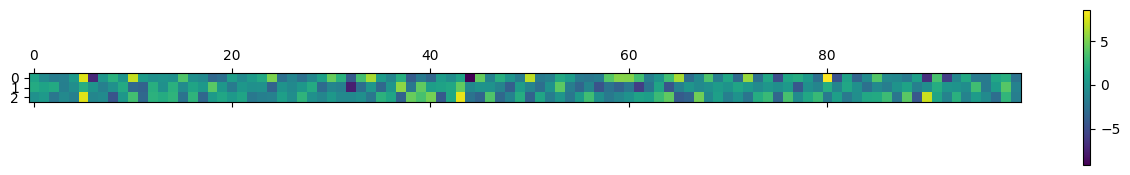

In [10]:
plt.matshow(res["mmml_forces"].T)
plt.colorbar()

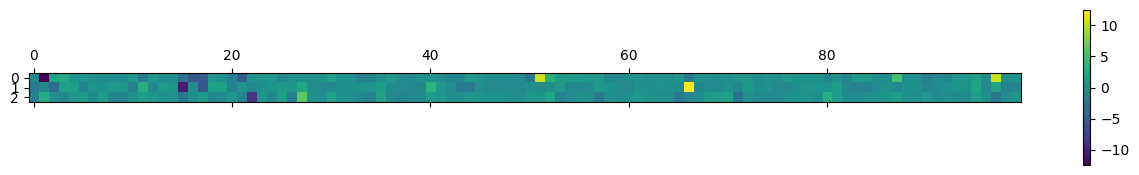

In [11]:
plt.matshow(ref_forces_mm.T)
plt.colorbar()

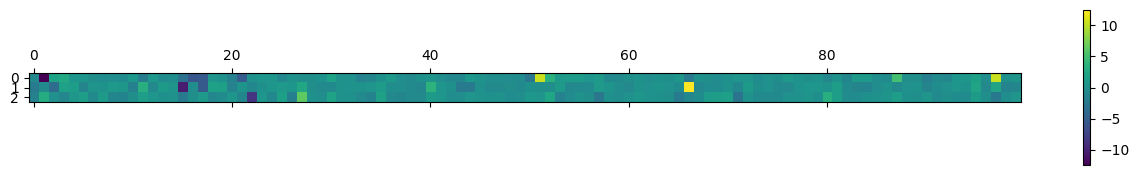

In [12]:
plt.matshow(res["mm_forces"].sum(axis=0).T)
plt.colorbar()

# 

In [507]:
from jax import jit


@jit
def switch_MM(    X,
    mm_energy,
    dif=10 ** (-6),
    MM_CUTON=6.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    
    # r =  (jnp.sum((X[5:].mean() - X[:5].mean())**2)*0.2)**0.5
    r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:].T.mean(axis=1))
    ML_CUTOFF = MM_CUTON - dif
    charmm_on_scale = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
    charmm_off_scale = smooth_cutoff(r - MM_CUTON, cutoff=MM_CUTOFF - MM_CUTON)
    # remove any sigularities
    charmm_off_scale = jax.numpy.nan_to_num(charmm_off_scale, posinf=1)


    mm_contrib = charmm_on_scale * mm_energy * charmm_off_scale
    # jax.debug.print("{a} {b} {c}", a=ml_energy, b=mm_energy, c=r)
    # jax.debug.print("{a} {b} {c}", a=charmm_on_scale, b=charmm_off_scale, c=ml_scale)
    return mm_contrib

switch_MM_grad = jax.grad(switch_ML)

@jit
def switch_ML(X,
    ml_energy,
    dif=10 ** (-6),
    MM_CUTON=6.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    
    # r =  (jnp.sum((X[5:].mean() - X[:5].mean())**2)*0.2)**0.5
    r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:].T.mean(axis=1))
    ML_CUTOFF = MM_CUTON - dif
    ml_scale = 1 - abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    ml_contrib = ml_scale * ml_energy
    return ml_contrib.sum()

switch_ML_grad = jax.grad(switch_ML)

@jit
def combine_with_sigmoid_E(
    X,
    mm_energy,
    ml_energy,
    dif=10 ** (-6),
    MM_CUTON=6.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    ml_contrib = switch_ML(X,ml_energy)
    mm_contrib = switch_ML(X,mm_energy)
    return mm_contrib + ml_contrib

R = dimers_ref["R"][takethese[1]]
import jax.numpy as jnp
X_dummy = jnp.array(R)
mm_energy_dummy = jnp.array( [1])
ml_energy_dummy = np.array( [1])
print(X_dummy)
r = jnp.linalg.norm(X_dummy[0] - X_dummy[5])
print(r)
value = combine_with_sigmoid_E(X_dummy, mm_energy_dummy, ml_energy_dummy)

combine_with_sigmoid_E_grad = jax.grad(combine_with_sigmoid_E, argnums=0, has_aux=False, holomorphic=False, allow_int=False, reduce_axes=())
grad = combine_with_sigmoid_E_grad(X_dummy, mm_energy_dummy, ml_energy_dummy)
value, np.array(grad)

Array[10, 3] n=30 x∈[-13.537, 15.129] μ=-0.592 σ=8.833 gpu:0
Array gpu:0 10.507


(Array gpu:0 0.,
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=float32))

In [508]:
XDUMM = jnp.zeros_like(X_dummy)
XDELTA = 0.00001
XDUMM = XDUMM.at[0,0].set(XDELTA)
print("aksjdhf", XDUMM)
value2 = combine_with_sigmoid_E(X_dummy + XDUMM, mm_energy_dummy, ml_energy_dummy)
value, value2, np.array((value2 - value)/XDELTA)

aksjdhf Array[10, 3] n=30 x∈[0., 1.000e-05] μ=3.333e-07 σ=1.795e-06 gpu:0


(Array gpu:0 0., Array gpu:0 0., array(0., dtype=float32))

In [509]:
# jnp.linalg.norm(
# X[:5] - (X[5:][None,:] * jnp.ones_like()

In [510]:
# Dimers

CG321EP, CG321RM, CLGA1EP, CLGA1RM, MM_CUTON = x0
set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)


read parameter card
* methanol
*
NONBONDED
CG321    0.0       -0.1800     2.0000   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       -0.4500    2.0280 ! CLET, DCLE, chloroethane, 1,1-dichloroethane
END



In [511]:
dimers_ref_path = Path("/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz")

dimers_ref = np.load(dimers_ref_path)
takethese = np.where(dimers_ref["N"] == 10)[0]
len(takethese)

NpzFile '/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz' with keys: N, E, Q, D, Z...

19000

r Array gpu:0 12.752
val_ml_s: Array gpu:0 0.
val_mm_s: Array gpu:0 0.
r Array gpu:0 12.524
val_ml_s: Array gpu:0 0.
val_mm_s: Array gpu:0 0.
r Array gpu:0 8.085
val_ml_s: Array gpu:0 0.
val_mm_s: Array gpu:0 -0.170
r Array gpu:0 8.959
val_ml_s: Array gpu:0 0.
val_mm_s: Array gpu:0 0.016
r Array gpu:0 10.274
val_ml_s: Array gpu:0 0.
val_mm_s: Array gpu:0 0.
r Array gpu:0 6.652
val_ml_s: Array gpu:0 0.
val_mm_s: Array gpu:0 -0.832
r Array gpu:0 8.068
val_ml_s: Array gpu:0 0.
val_mm_s: Array gpu:0 0.347
r Array gpu:0 10.741
val_ml_s: Array gpu:0 0.
val_mm_s: Array gpu:0 0.
r Array gpu:0 14.552
val_ml_s: Array gpu:0 0.
val_mm_s: Array gpu:0 0.
r Array gpu:0 5.737
val_ml_s: Array gpu:0 0.596
val_mm_s: Array gpu:0 0.
r Array gpu:0 10.390
val_ml_s: Array gpu:0 0.
val_mm_s: Array gpu:0 0.
r Array gpu:0 8.689
val_ml_s: Array gpu:0 0.
val_mm_s: Array gpu:0 -0.003
r Array gpu:0 9.214
val_ml_s: Array gpu:0 0.
val_mm_s: Array gpu:0 0.
r Array gpu:0 9.683
val_ml_s: Array gpu:0 0.
val_mm_s: Array gp

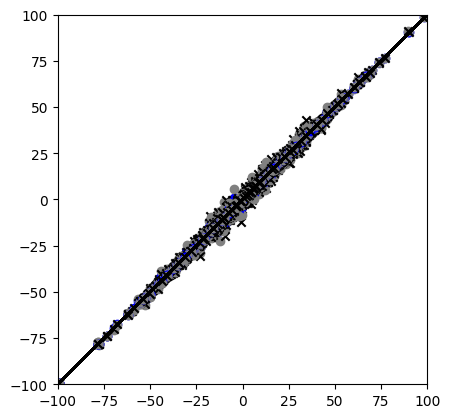

In [574]:
errors_ml = []
errors_mmml = []
E_ml = []
E_mmml = []
E_ref = []


for takeidx in takethese[3::50]:
    R = dimers_ref["R"][takeidx]
    Z = dimers_ref["Z"][takeidx]
    N = dimers_ref["N"][takeidx]

    X = R.copy()
    # r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:].T.mean(axis=1))
    # r =  (jnp.sum((X[5:].mean() - X[:5].mean())**2)*0.2)**0.5
    r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:].T.mean(axis=1))
    if r:
        # break
        # print(N)
        assert N == 10
        dimer_ref_E = dimers_ref["E"][takeidx] * 23.06
        tmp_coord = coor.get_positions().to_numpy() * 0
        tmp_coord[:len(R), :] = R
        set_pycharmm_xyz(tmp_coord)
        reset_block()
        a = 1
        b = 2
        block = f"""BLOCK
        CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
        CALL 2 SELE (RESID {a} .OR. RESID {b}) END
        COEFF 1 1 0.0
        COEFF 2 2 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
        COEFF 1 2 0.0
        END
        """
        _ = pycharmm.lingo.charmm_script(block)
        energy.show()
        ref_forces_mm = get_forces_pycharmm()
        chm_d_E = energy.get_vdw() + energy.get_elec()
        # print(chm_d_E)
        ase_atoms_dimer.set_positions(R)
        ase_atoms_dimer.set_atomic_numbers(Z)
        ase_dimer_E = ase_atoms_dimer.get_potential_energy()
        ase_dimer_F = ase_atoms_dimer.get_forces()
        dimers_ref_F = dimers_ref["F"][takeidx] * 23.06
        ase_atoms_monomer.set_positions(R[:5])
        ase_atoms_monomer.set_atomic_numbers(Z[:5])
        ase_monomer_E1 = ase_atoms_monomer.get_potential_energy()
        ase_monomer_F1 = ase_atoms_monomer.get_forces()
        ase_atoms_monomer.set_positions(R[5:])
        ase_atoms_monomer.set_atomic_numbers(Z[:5])
        ase_monomer_E2 = ase_atoms_monomer.get_potential_energy()
        ase_monomer_F2 = ase_atoms_monomer.get_forces()
        ase_dimer_forces = np.array(ase_dimer_F) 
        ase_dimer_forces_errors = ase_dimer_forces - dimers_ref_F
        jax.numpy.array(ase_dimer_forces_errors)
        ase_dimers_1body_forces = np.concatenate([ase_monomer_F1, ase_monomer_F2]) 
        
        ase_dimers_1body_force_errors = ase_dimers_1body_forces - dimers_ref_F
        
        jax.numpy.array(ase_dimers_1body_force_errors)
        
        mixed_1b2b =  (2 * ase_dimers_1body_forces) - ase_dimer_forces 
        mixed_1b2b_errors = mixed_1b2b - dimers_ref_F
        chm_ref_dimers = ref_forces_mm.to_numpy()[:10,]
        chm_ref_dimers_errors = chm_ref_dimers - (ase_dimer_forces - ase_dimers_1body_forces)
        # print(jax.numpy.array(chm_ref_dimers_errors))
        
        X = jnp.array(R.copy())
        r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:].T.mean(axis=1))
    
        
    
        final_energy = (ase_monomer_E1 + ase_monomer_E2) - ase_dimer_E #- chm_d_E
        final_e1 = combine_with_sigmoid_E(X, chm_d_E, final_energy)
        final_e2 = final_e1 + (ase_monomer_E1 + ase_monomer_E2)
        val_mm_s = switch_MM(X, chm_d_E)
        val_ml_s = switch_ML(X, final_energy)
        grad_mm_s = switch_MM_grad(X, chm_d_E)
        grad_ml_s = switch_ML_grad(X, final_energy)

        ml_forces_out = (ase_dimers_1body_forces - ase_dimer_forces) * val_ml_s + grad_ml_s * final_energy 
        mm_forces_out = (chm_ref_dimers) * val_mm_s + grad_mm_s * chm_d_E
        
        # add monomer contributions
        final_energy += (ase_monomer_E1 + ase_monomer_E2)
      
        # final forces
        # dU/dP dP/dX
        final_forces =  ml_forces_out + mm_forces_out + ase_dimers_1body_forces
        # print(final_forces)

        # print(dimers_ref_F)
        
        # print("ML Forces Components:")
        # print("ase_dimers_1body_forces shape:", ase_dimers_1body_forces.shape)
        # print("ase_dimers_1body_forces:", ase_dimers_1body_forces)
        # print("\nase_dimer_forces shape:", ase_dimer_forces.shape)
        # print("ase_dimer_forces:", ase_dimer_forces)
        # print("\nval_ml_s shape:", val_ml_s.shape)
        print("r", r)
        print("val_ml_s:", val_ml_s)
        # print("\ngrad_ml_s shape:", grad_ml_s.shape)
        # print("grad_ml_s:", grad_ml_s)
        # print("\nfinal_energy shape:", final_energy.shape)
        # print("final_energy:", final_energy)
        
        # print("\nMM Forces Components:")
        # print("chm_ref_dimers shape:", chm_ref_dimers.shape)
        # print("chm_ref_dimers:", chm_ref_dimers)
        # print("\nval_mm_s shape:", val_mm_s.shape)
        print("val_mm_s:", val_mm_s)
        # print("\ngrad_mm_s shape:", grad_mm_s.shape)
        # print("grad_mm_s:", grad_mm_s)
        # # print("\nchm_d_E shape:", chm_d_E.shape)
        # print("chm_d_E:", chm_d_E)
        
        # print("\nFinal Forces:")
        # print("ml_forces_out shape:", ml_forces_out.shape)
        # print("ml_forces_out:", ml_forces_out)
        # print("\nmm_forces_out shape:", mm_forces_out.shape)
        # print("mm_forces_out:", mm_forces_out)


        
        # print("grad", grad)
        e_text = "\nRef.:{:.1f}\n2B ML.:{:.1f},({:.1f})\n2B MM/ML:{:.1f},({:.1f})\n1B ML{:.1f},({:.1f})".format( *[float(x) for x in [ dimer_ref_E,
                                                               final_energy, final_energy - dimer_ref_E, 
                                                               final_e2, final_e2 - dimer_ref_E, 
                                                                                          (ase_monomer_E1 + ase_monomer_E2), 
                                                                                          (ase_monomer_E1 + ase_monomer_E2)-dimer_ref_E]])
        # plt.scatter(ase_dimer_forces, ase_dimers_1body_forces, label = "1B ML vs 2B ML")
        # plt.scatter(dimers_ref_F, ase_dimers_1body_forces,  color="b")
        # plt.scatter(dimers_ref_F, mixed_1b2b,color="grey")
        # plt.scatter(dimers_ref_F, final_forces,  color="k")

        errors_ml.append(final_energy - dimer_ref_E)
        errors_mmml.append(final_e2 - dimer_ref_E)
        E_ml.append(final_energy )
        E_mmml.append(final_e2)
        E_ref.append( dimer_ref_E)

        plt.scatter(dimers_ref_F, ase_dimers_1body_forces, label = "1B ML vs Ref.", color="b")
        plt.scatter(dimers_ref_F, mixed_1b2b, label = "2B ML vs Ref", color="grey")
        plt.scatter(dimers_ref_F, final_forces, marker="x", label = "2B MM/ML vs Ref", color="k")
        ax = plt.gca()
        # plt.legend()
        # plt.suptitle("$r =$"+f"{float(r):.1f} "+" $\\rm \\AA$"+f"   {e_text}", fontsize=15, x=0, y=1)
        ax.set_aspect("equal")
        ax.set_xlim(-100,100)
        ax.set_ylim(-100,100)
        plt.plot([0,1], [0,1], transform=ax.transAxes, color="k")
        # plt.show()

plt.scatter(dimers_ref_F, ase_dimers_1body_forces, label = "1B ML vs Ref.", color="b")
plt.scatter(dimers_ref_F, mixed_1b2b, label = "2B ML vs Ref", color="grey")
plt.scatter(dimers_ref_F, final_forces, marker="x", label = "2B MM/ML vs Ref", color="k")

plt.show()

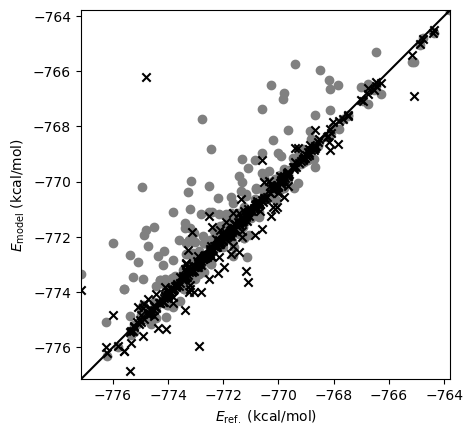

In [584]:
plt.scatter(E_ref, E_ml,  label="2B ML vs Ref", color="grey")
plt.scatter( E_ref, E_mmml, label="2B MM/ML vs Ref", marker="x", color="k")

plt.xlabel("$E_{\\rm ref.}$ (kcal/mol)")
plt.ylabel("$E_{\\rm model}$ (kcal/mol)")

ax = plt.gca()
# plt.legend()
# plt.suptitle("$r =$"+f"{float(r):.1f} "+" $\\rm \\AA$"+f"   {e_text}", fontsize=15, x=0, y=1)
ax.set_aspect("equal")
_min, _max = np.min(E_ref), np.max(E_ref)

ax.set_xlim(_min, _max )
ax.set_ylim(_min, _max )
plt.plot([0,1], [0,1], transform=ax.transAxes, color="k")

In [585]:
mu_errors_ml = np.mean(errors_ml) 
sig_errors_ml = np.std(errors_ml) 
mu_errors_mmml = np.mean(errors_mmml) 
sig_errors_mmml = np.std(errors_mmml) 

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_145834/2188405488.py:1: SyntaxWarning: invalid escape sequence '\m'
  text1 = "$\mu$,$\sigma$"+ "= {}".format(f"{mu_errors_ml:.3f}" + "\n       " + f"{sig_errors_ml:.3f}")
/tmp/ipykernel_145834/2188405488.py:2: SyntaxWarning: invalid escape sequence '\m'
  text2 = "$\mu$,$\sigma$"+ "= {}".format(f"{mu_errors_mmml:.3f}" + "\n       " + f"{sig_errors_mmml:.3f}")


Text(4, 50, '$\\mu$,$\\sigma$= 1.828\n       13.514')

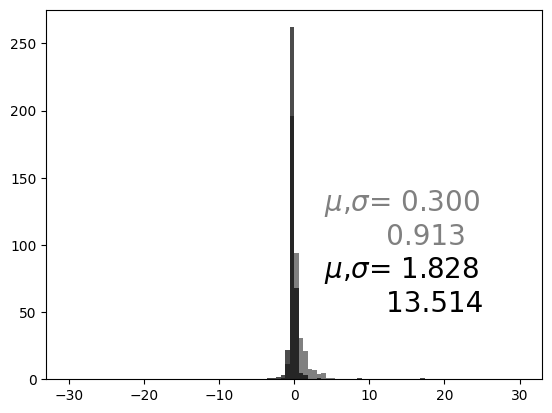

In [586]:
text1 = "$\mu$,$\sigma$"+ "= {}".format(f"{mu_errors_ml:.3f}" + "\n       " + f"{sig_errors_ml:.3f}")
text2 = "$\mu$,$\sigma$"+ "= {}".format(f"{mu_errors_mmml:.3f}" + "\n       " + f"{sig_errors_mmml:.3f}")
plt.hist(errors_ml, bins=100, range=(-30,30), alpha=1, color="gray")

plt.hist(errors_mmml, bins=100, range=(-30,30), alpha=0.7, color="k")

plt.text(4,100, text1, fontsize=20, color="gray")
plt.text(4,50, text2, fontsize=20, color="k")

In [209]:
ase.Atoms(Z, R)

Atoms(symbols='CH2Cl2CH2Cl2', pbc=False)

In [533]:
np.mean(errors_ml), np.std(errors_ml)

(0.3160712, 0.808979)

In [587]:
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
import e3x
import jax
import numpy as np


@jax.jit
def ase_dimer_energies_and_forces(positions):
    # return 
    pass


class AseDimerCalculator(ase_calc.Calculator):
    implemented_properties = ["energy", "forces", "dipole"]

    def calculate(
        self, atoms, properties, system_changes=ase.calculators.calculator.all_changes
    ):
        ase_calc.Calculator.calculate(self, atoms, properties, system_changes)

        self.results["energy"] = output[
            "energy"
        ].squeeze()  # * (ase.units.kcal/ase.units.mol)
        self.results["forces"] = output[
            "forces"
        ]  # * (ase.units.kcal/ase.units.mol) #/ase.units.Angstrom

In [214]:
ase_atoms_dimer.set_positions(R)
ase_atoms_dimer.set_atomic_numbers(Z)
ase_dimer_E = ase_atoms_dimer.get_potential_energy()
ase_dimer_F = ase_atoms_dimer.get_forces()
dimers_ref_F = dimers_ref["F"][takeidx] * 23.06
ase_atoms_monomer.set_positions(R[:5])
ase_atoms_monomer.set_atomic_numbers(Z[:5])
ase_monomer_E1 = ase_atoms_monomer.get_potential_energy()
ase_monomer_F1 = ase_atoms_monomer.get_forces()
ase_atoms_monomer.set_positions(R[5:])
ase_atoms_monomer.set_atomic_numbers(Z[:5])
ase_monomer_E2 = ase_atoms_monomer.get_potential_energy()
ase_monomer_F2 = ase_atoms_monomer.get_forces()
ase_dimer_forces = np.array(ase_dimer_F) 
ase_dimer_forces_errors = ase_dimer_forces - dimers_ref_F
jax.numpy.array(ase_dimer_forces_errors)
ase_dimers_1body_forces = np.concatenate([ase_monomer_F1, ase_monomer_F2]) 

ase_dimers_1body_force_errors = ase_dimers_1body_forces - dimers_ref_F

jax.numpy.array(ase_dimers_1body_force_errors)

mixed_1b2b = -(-2 * ase_dimers_1body_forces + ase_dimer_forces)
mixed_1b2b_errors = mixed_1b2b - dimers_ref_F
chm_ref_dimers = ref_forces_mm.to_numpy()[:10,]
chm_ref_dimers_errors = chm_ref_dimers - (ase_dimer_forces - ase_dimers_1body_forces)
print(jax.numpy.array(chm_ref_dimers_errors))
plt.scatter(ase_dimer_forces, ase_dimers_1body_forces, label = "1B ML vs 2B ML")
plt.scatter(dimers_ref_F, ase_dimers_1body_forces, label = "1B ML vs REF")
plt.scatter(dimers_ref_F, mixed_1b2b, label = "2B ML vs Ref")
plt.scatter(dimers_ref_F, mixed_1b2b + chm_ref_dimers, label = "2B MMML vs Ref")
ax = plt.gca()
plt.legend()
plt.plot([0,1], [0,1], transform=ax.transAxes)
ax.set_aspect("equal")

Array gpu:0 -772.585

array([[ 31.71260728,   3.15437504, -38.96070689],
       [-37.18663032,  -1.77900946,  29.16225141],
       [ -1.3567842 ,  -2.06351675,  -0.98180092],
       [  6.03250777,  12.03930755,  13.63808835],
       [ -3.60968392, -12.09439948,  -5.50343071],
       [ 21.96408554, -11.17503056,  -6.07762719],
       [-22.11884337,   9.29663979,  -7.62894071],
       [ -5.43102619, -16.11345468,   1.16486362],
       [  2.93751724,  10.09885238,  13.77699213],
       [  7.05623832,   8.63624803,   1.41028717]])

In [216]:

ase_monomer_E1, ase_monomer_E2, ase_monomer_E1 + ase_monomer_E2, ase_dimer_E, ase_dimer_E - (ase_monomer_E1 + ase_monomer_E2)

(Array gpu:0 -386.439,
 Array gpu:0 -386.932,
 Array gpu:0 -773.371,
 Array gpu:0 -772.585,
 Array gpu:0 0.786)

In [217]:
dimers_ref_F

array([[ 31.71260728,   3.15437504, -38.96070689],
       [-37.18663032,  -1.77900946,  29.16225141],
       [ -1.3567842 ,  -2.06351675,  -0.98180092],
       [  6.03250777,  12.03930755,  13.63808835],
       [ -3.60968392, -12.09439948,  -5.50343071],
       [ 21.96408554, -11.17503056,  -6.07762719],
       [-22.11884337,   9.29663979,  -7.62894071],
       [ -5.43102619, -16.11345468,   1.16486362],
       [  2.93751724,  10.09885238,  13.77699213],
       [  7.05623832,   8.63624803,   1.41028717]])

In [218]:
ase_monomer_F1, ase_monomer_F2

(Array[5, 3] n=15 x∈[-40.072, 32.323] μ=6.358e-08 σ=19.334 gpu:0,
 Array[5, 3] n=15 x∈[-22.152, 22.392] μ=4.768e-08 σ=11.314 gpu:0)

array([[ 32.163017 ,   2.91776  , -38.882236 ],
       [-37.897293 ,  -1.7325917,  29.286825 ],
       [ -1.199576 ,  -2.1617024,  -1.08329  ],
       [  5.891751 ,  12.199342 ,  13.456172 ],
       [ -3.561026 , -11.923339 ,  -5.6668916],
       [ 21.929747 , -11.777107 ,  -6.4283113],
       [-22.39939  ,   9.298324 ,  -7.5176296],
       [ -5.6309342, -15.958981 ,   1.2975115],
       [  3.6866329,  10.497367 ,  13.847669 ],
       [  7.017073 ,   8.640932 ,   1.6901848]], dtype=float32)

Array[10, 3] n=30 x∈[-0.711, 0.749] μ=1.082e-06 σ=0.285 gpu:0

Array[10, 3] n=30 x∈[-4.570, 3.425] μ=8.901e-07 σ=1.433 gpu:0

In [222]:
dimers_ref_F

array([[ 31.71260728,   3.15437504, -38.96070689],
       [-37.18663032,  -1.77900946,  29.16225141],
       [ -1.3567842 ,  -2.06351675,  -0.98180092],
       [  6.03250777,  12.03930755,  13.63808835],
       [ -3.60968392, -12.09439948,  -5.50343071],
       [ 21.96408554, -11.17503056,  -6.07762719],
       [-22.11884337,   9.29663979,  -7.62894071],
       [ -5.43102619, -16.11345468,   1.16486362],
       [  2.93751724,  10.09885238,  13.77699213],
       [  7.05623832,   8.63624803,   1.41028717]])

In [239]:
mixed_1b2b

array([[ 32.483543 ,   0.95648  , -41.26147  ],
       [-36.70958  ,  -2.1221762,  28.346369 ],
       [ -1.1645294,  -1.7931879,   0.3871022],
       [ 13.023771 ,  14.4731   ,  20.366581 ],
       [ -3.0300756, -10.813685 ,  -4.949159 ],
       [ 22.85412  ,  -8.979485 ,  -8.60416  ],
       [-21.90547  ,   8.818791 ,  -7.331501 ],
       [ -5.2750125, -16.35389  ,   1.1696681],
       [ -6.9513316,   7.2401075,   8.598065 ],
       [  6.6745667,   8.57394  ,   3.2785037]], dtype=float32)

Array[10, 3] n=30 x∈[-9.889, 6.991] μ=6.119e-07 σ=2.972 gpu:0

In [241]:
mixed_1b2b_errors

array([[ 7.70936117e-01, -2.19789501e+00, -2.30076390e+00],
       [ 4.77050856e-01, -3.43166706e-01, -8.15882623e-01],
       [ 1.92254756e-01,  2.70328891e-01,  1.36890311e+00],
       [ 6.99126352e+00,  2.43379216e+00,  6.72849261e+00],
       [ 5.79608375e-01,  1.28071407e+00,  5.54271562e-01],
       [ 8.90034715e-01,  2.19554600e+00, -2.52653312e+00],
       [ 2.13373472e-01, -4.77848405e-01,  2.97439699e-01],
       [ 1.56013702e-01, -2.40434785e-01,  4.80445542e-03],
       [-9.88884885e+00, -2.85874485e+00, -5.17892676e+00],
       [-3.81671579e-01, -6.23077533e-02,  1.86821648e+00]])

Array[10, 3] n=30 x∈[-6.372, 4.490] μ=-2.146e-07 σ=1.926 gpu:0


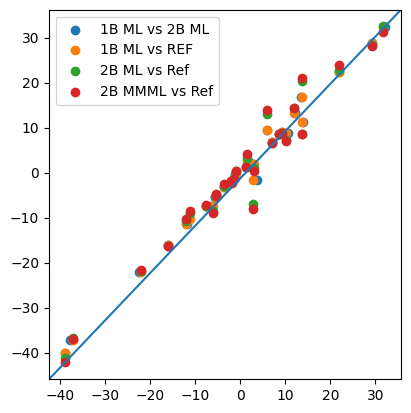

In [263]:
mixed_1b2b - chm_ref_dimers

array([[ 33.6089149 ,   1.44738849, -40.33346756],
       [-36.35802719,  -1.89761534,  28.63936462],
       [ -0.90028634,  -1.68885186,   0.5128088 ],
       [ 12.09998298,  14.53436338,  19.70253961],
       [ -3.57725277, -11.24657959,  -5.19879955],
       [ 21.7842105 ,  -9.42151661,  -8.21097524],
       [-22.07058305,   8.77873089,  -7.39219186],
       [ -5.43613913, -16.47312067,   1.09285372],
       [ -5.8986784 ,   7.45001143,   8.68560442],
       [  6.74786172,   8.51718536,   2.50226083]])

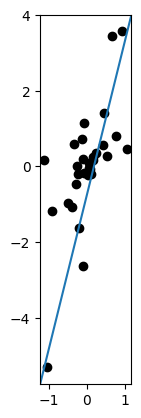

In [252]:
plt.scatter(chm_ref_dimers , -(ase_dimer_forces - ase_dimers_1body_forces), color="k")
ax = plt.gca()
plt.plot([0,1], [0,1], transform=ax.transAxes)
ax.set_aspect("equal")

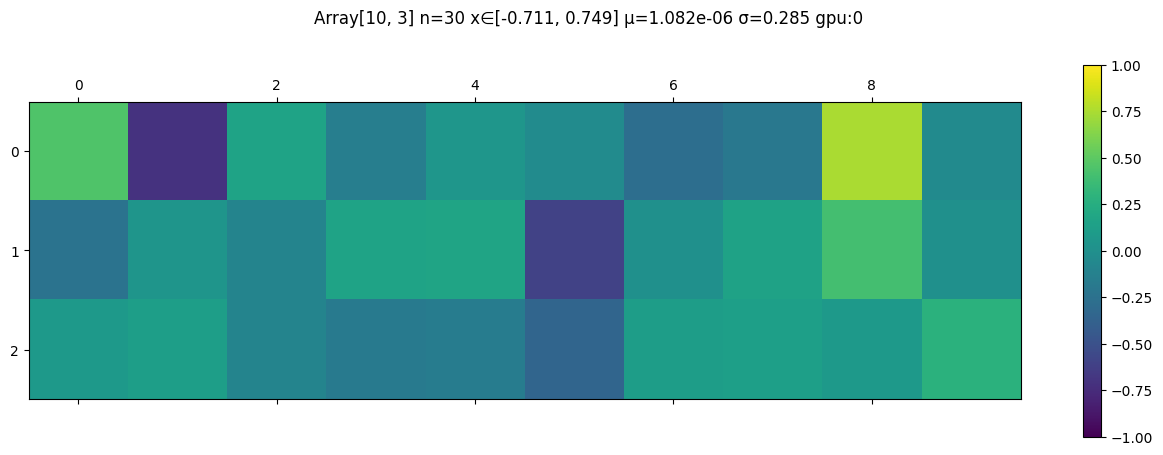

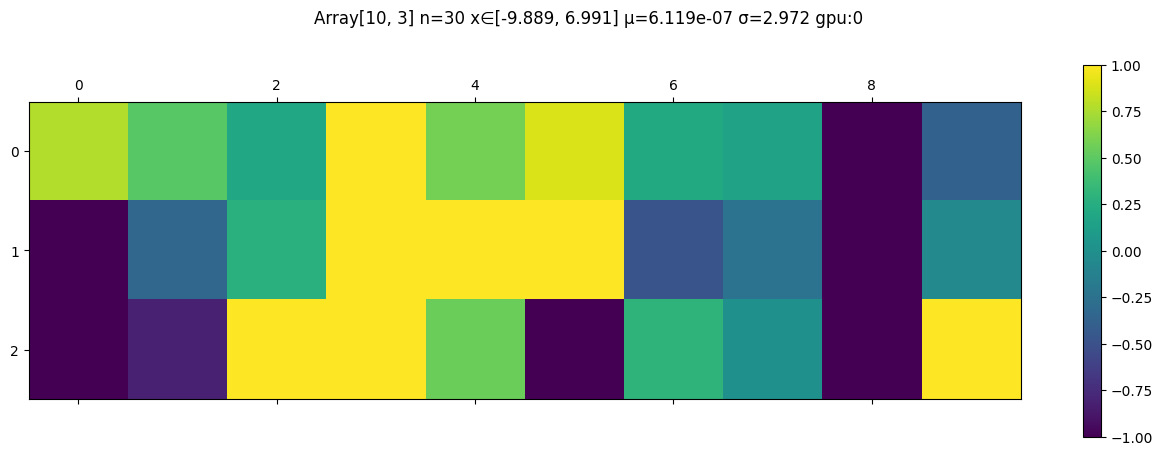

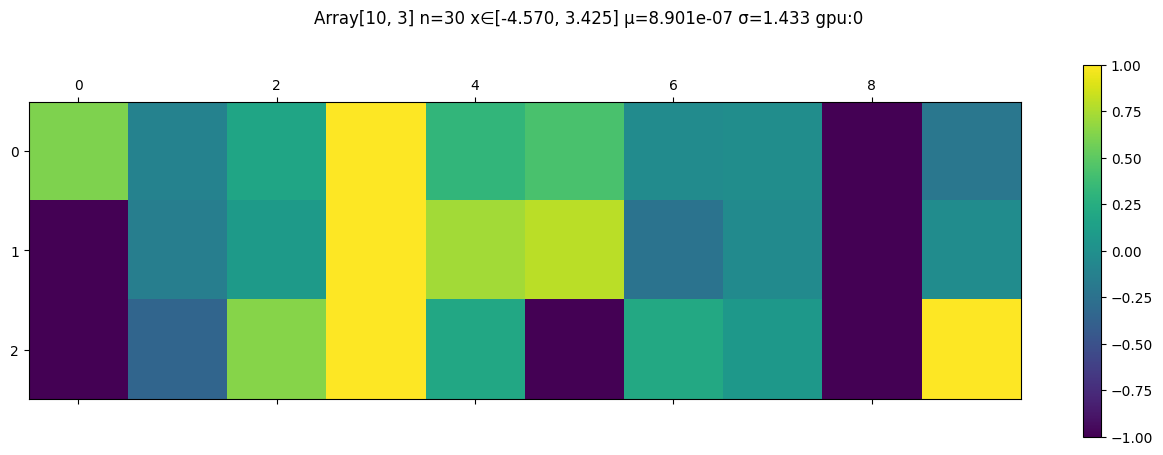

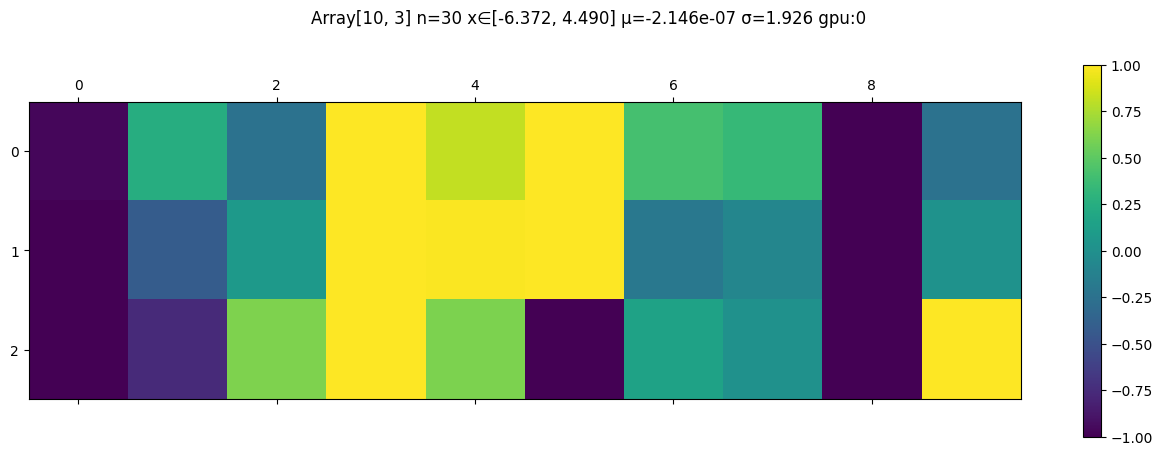

In [247]:
for _ in [
    ase_dimer_forces_errors,
    mixed_1b2b_errors, 
    ase_dimers_1body_force_errors, 
    chm_ref_dimers_errors
]:
    plt.matshow(_.T, vmin=-1, vmax=1)
    plt.suptitle(jax.numpy.array(_))
    plt.colorbar()
    plt.show()


In [244]:
final_energy = 2 * (ase_monomer_E1 + ase_monomer_E2) - ase_dimer_E #- chm_d_E
final_energy, dimer_ref_E

Array gpu:0 -774.156

In [245]:

# plt.matshow(dimers_ref_F.T)
# plt.colorbar()
# dimers_ref_F

In [174]:
dimer_ref_E

-772.6703850191601

In [169]:
dimer_ref_E - final_energy

# plt.matshow(ref_forces_mm.T)
# plt.colorbar()

Array gpu:0 1.486

In [159]:
R = dimers_ref["R"][takeidx]
Z = dimers_ref["Z"][takeidx]

In [161]:
import jax.numpy as jnp
X_dummy = R.copy()
mm_energy_dummy = jnp.array( [1])
ml_energy_dummy = np.array( [1])

value = combine_with_sigmoid_E(X_dummy, mm_energy_dummy, ml_energy_dummy)

grad_fn = jax.grad(combine_with_sigmoid_E, argnums=0, has_aux=False, holomorphic=False, allow_int=False, reduce_axes=())
grad = grad_fn(X_dummy, mm_energy_dummy, ml_energy_dummy)

In [163]:
value

Array gpu:0 0.989

In [164]:
np.array(grad)

array([[ 0.033968  ,  0.01721521,  0.017291  ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.033968  , -0.01721521, -0.017291  ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [165]:
grad_fn_vmap = jax.vmap(grad_fn) #, (0, 1, 1), 0)

In [166]:
X_dummy_b = X_dummy[None, ...].repeat(3, axis=0)
mm_energy_dummy_b = mm_energy_dummy[None, ...].repeat(3, axis=0)
ml_energy_dummy_b = ml_energy_dummy[None, ...].repeat(3, axis=0)
# X_dummy_b

In [167]:
vmap_grad = grad_fn_vmap(X_dummy_b, mm_energy_dummy_b, ml_energy_dummy_b)
print(np.array(vmap_grad))

[[[ 0.033968    0.01721521  0.017291  ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [-0.033968   -0.01721521 -0.017291  ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.033968    0.01721521  0.017291  ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [-0.033968   -0.01721521 -0.017291  ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.033968    0.01721521  0.017291  ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.      

In [168]:
mixed_1b2b

array([[ 32.163017 ,   2.91776  , -38.882236 ],
       [-37.897293 ,  -1.7325917,  29.286825 ],
       [ -1.199576 ,  -2.1617024,  -1.08329  ],
       [  5.891751 ,  12.199342 ,  13.456172 ],
       [ -3.561026 , -11.923339 ,  -5.6668916],
       [ 21.929747 , -11.777107 ,  -6.4283113],
       [-22.39939  ,   9.298324 ,  -7.5176296],
       [ -5.6309342, -15.958981 ,   1.2975115],
       [  3.6866326,  10.497367 ,  13.847669 ],
       [  7.017073 ,   8.640932 ,   1.6901848]], dtype=float32)

In [119]:
vmap_grad.sum(axis=0)

Array[10, 3] n=30 x∈[-0.102, 0.102] μ=-2.484e-10 σ=0.032 gpu:0